<font size="6"> **Model Building** </font>

In [18]:
%%capture
%run 00_mlmod_load_data.ipynb

In [19]:
RND_SEED = 123
KFOLDS = 3
pd.set_option('precision', 4)


In [20]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

In [302]:
def direction_accuracy_func(y_true, y_pred, **kwargs):
    kind = kwargs.get('kind', 'global')
    w_fp = kwargs.get('w_fp', 2)
    w_fn = kwargs.get('w_fn', 2)
    nobs = len(y_true)
    y_true_pos = (y_true>0).astype(int)
    y_pred_pos = (y_pred>0).astype(int)
    xtab = pd.crosstab(index=y_true_pos, columns=y_pred_pos)
    try:
        tp = xtab.loc[0,0]
    except:
        tp = 0
    try:
        tn = xtab.loc[1,1]
    except:
        tn = 0
    try:
        fp = xtab.loc[0,1]
    except:
        fp = 0
    try:
        fn = xtab.loc[1,0]
    except:
        fn = 0
    if kind == 'global':
        acc = (tp + tn)/nobs
    elif kind == 'upwards':
        acc = tp/(tp + fn)
    elif kind == 'downwards':
        acc = tn/(tn + fp)
    elif kind == 'weighted':
        acc = (tp + tn)/(tp + tn + fp*w_fp + fn*w_fn)
    else:
        raise ValueError("kind must be: global, upwards, downwards or weighted")
        
    return acc
direction_accuracy = make_scorer(direction_accuracy_func, greater_is_better=True, kind='global')
upwards_direction_accuracy = make_scorer(direction_accuracy_func, greater_is_better=True, kind='upwards')
downwards_direction_accuracy = make_scorer(direction_accuracy_func, greater_is_better=True, kind='downwards')
weighted_direction_accuracy = make_scorer(direction_accuracy_func, greater_is_better=True, kind='weighted', w_fp=2., w_fn=1.)

In [303]:
y_true = np.array([0.1, -0.1, 0.2, -0.2])
y_pred = np.array([0.01, 0.01, -0.02, -0.02])
direction_accuracy_func(y_true, y_pred)

0.5

In [304]:
direction_accuracy_func(y_true, y_pred, kind='upwards')

0.5

In [305]:
direction_accuracy_func(y_true, y_pred, kind='downwards')

0.5

In [306]:
direction_accuracy_func(y_true, y_pred, kind='weighted', w_fp=2, w_fn=1.5)

0.36363636363636365

In [307]:
scoring = {'neg_root_mean_squared_error':'neg_root_mean_squared_error',
           'w_accuracy': weighted_direction_accuracy,
           'accuracy': direction_accuracy,
          'up_accuracy': upwards_direction_accuracy,
          'down_accuracy': downwards_direction_accuracy}

In [308]:
tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)

In [309]:
hpgrid_ridge = {'alpha': [10.0**x for x in range(-3,3)]}
ridge = Ridge(fit_intercept=False, random_state=RND_SEED)

In [310]:
ridge_cv = GridSearchCV(ridge, hpgrid_ridge, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=tscv_smp, return_train_score=True)
res_ridge_cv = ridge_cv.fit(X_train_smp[features], y_train_smp)

In [311]:
(y_train_smp>0).value_counts()

True     32378
False    25131
Name: target, dtype: int64

In [312]:
res_ridge_cv_df = pd.DataFrame(res_ridge_cv.cv_results_)

In [313]:
res_ridge_cv_df[['params', 'std_test_w_accuracy', 'mean_test_w_accuracy', 'mean_test_accuracy',
                 'mean_test_down_accuracy',
                 'mean_test_up_accuracy']]

,params,std_test_w_accuracy,mean_test_w_accuracy,mean_test_accuracy,mean_test_down_accuracy,mean_test_up_accuracy
0,{'alpha': 0.001},0.0527,0.2922,0.5513,0.6016,0.5045
1,{'alpha': 0.01},0.0308,0.2697,0.5602,0.5892,0.5138
2,{'alpha': 0.1},0.0274,0.2665,0.5623,0.5882,0.5158
3,{'alpha': 1.0},0.0260,0.2647,0.5623,0.5872,0.5156
4,{'alpha': 10.0},0.0154,0.2437,0.5662,0.5779,0.5282
5,{'alpha': 100.0},0.0086,0.2062,0.5588,0.5599,0.5279


In [314]:
res_ridge_cv.best_score_

0.2921914978301902

In [322]:
champ_ridge_hparms = res_ridge_cv.cv_results_['params'][2]
champ_ridge = Ridge(fit_intercept=False, random_state=RND_SEED)
champ_ridge.set_params(**champ_ridge_hparms)
champ_ridge.fit(X_train_smp[features], y_train_smp)

Ridge(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)

In [323]:
p_test = pd.Series(index=y_test_full.index, data=champ_ridge.predict(X_test_full[features]))

In [324]:
ridge_sum_df = mle_utils.predict_and_score(champ_ridge,
                                           X_train_full[features], y_train_full,
                                           X_test_full[features], y_test_full, kind='reg')
ridge_sum_df

train_pmean           0.0035
train_score           0.0008
valid_pmean           0.0083
valid_score           0.0015
train_acc_target<0    0.3061
train_acc_target>0    0.7843
train_acc             0.5751
valid_acc             0.5023
valid_acc_target<0    0.1049
valid_acc_target>0    0.8922
dtype: float64

In [ ]:
# overlapper

In [47]:

rf_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)

In [48]:
hpgrid_rf = {'max_samples': [0.25, 0.5, 0.75],
            'max_features': [0.25, 0.5, 0.75],
            'min_samples_leaf': [250, 500, 1000, 2500, 5000]}
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)

In [49]:
rf_cv = GridSearchCV(rf, hpgrid_rf, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=rf_tscv_smp, return_train_score=True)
res_rf_cv = rf_cv.fit(X_train_smp, y_train_smp)

In [296]:
rf_params_df = pd.DataFrame(res_rf_cv.cv_results_['params'])
rf_metrics_df = pd.DataFrame(res_rf_cv.cv_results_).drop(columns='params')
rf_sum_df = rf_params_df.join(rf_metrics_df)
rf_sum_df[rf_params_df.columns.tolist() + ['std_test_neg_root_mean_squared_error', 'mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error']].sort_values(by='rank_test_neg_root_mean_squared_error').head(20)

,ccp_alpha,max_features,max_samples,min_samples_leaf,std_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
8,0.0,0.25,0.50,1000,0.0008,-0.0286,1
26,0.0,0.50,0.25,1000,0.0008,-0.0286,2
2,0.0,0.25,0.25,1000,0.0008,-0.0286,3
39,0.0,0.50,0.75,2500,0.0009,-0.0286,4
15,0.0,0.25,0.75,2500,0.0008,-0.0286,5
1,0.0,0.25,0.25,500,0.0008,-0.0286,6
50,0.0,0.75,0.25,1000,0.0009,-0.0286,7
14,0.0,0.25,0.75,1000,0.0008,-0.0286,8
63,0.0,0.75,0.75,2500,0.0009,-0.0287,9
9,0.0,0.25,0.50,2500,0.0009,-0.0287,10


In [51]:
res_rf_cv.best_score_

-0.02859316459860702

In [52]:
champ_rf = res_rf_cv.best_estimator_
champ_rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.25, max_leaf_nodes=None,
                      max_samples=0.5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1000,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=-1, oob_score=True,
                      random_state=123, verbose=0, warm_start=False)

In [53]:
p_test = pd.Series(index=y_test_full.index, data=champ_rf.predict(X_test_full))

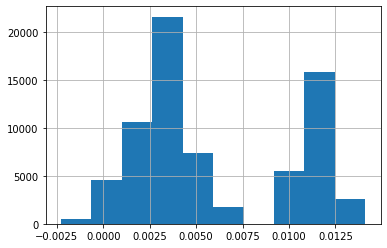

In [54]:
p_test.hist()

In [55]:
rf_sum_df = mle_utils.predict_and_score(champ_rf,
                                        X_train_full, y_train_full,
                                        X_test_full, y_test_full, kind='reg')
rf_sum_df

train_pmean           0.0036
train_score           0.0008
valid_pmean           0.0059
valid_score           0.0014
oob_score             0.0666
train_acc_target<0    0.2666
train_acc_target>0    0.8882
train_acc             0.6162
valid_acc             0.5068
valid_acc_target<0    0.0451
valid_acc_target>0    0.9598
dtype: float64